# BAP1 proteomics cis comparison

BAP1 is known as a tumor suppressor and a deubiquitinase. "The presence of ubiquitin molecules on a protein can affect the activity of the protein and its interactions with other proteins. The ubiquitin "tag" also promotes breakdown (degradation) of a protein. By removing ubiquitin, BAP1 helps regulate the function of many proteins involved in diverse cellular processes. The BAP1 protein is thought to help control cell growth and division (proliferation) and cell death" (https://ghr.nlm.nih.gov/gene/BAP1).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [132]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

In [133]:
renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'BAP1']

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
0,BAP1,0.154545,0.063636,0.090909


## Step 3: Select BAP1, a frequently mutated gene

In [126]:
gene = 'BAP1'

## Step 4: Select proteomics

In [4]:
omics = rc_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [127]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [128]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

        Comparison   P_Value
0  BAP1_proteomics  0.010487


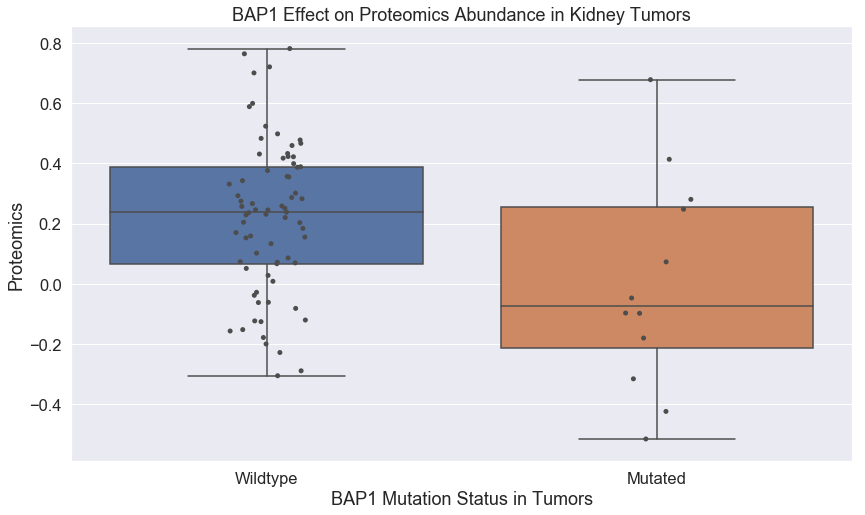

In [129]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Compare missense and truncation mutation types

In [137]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Only truncation type mutations found for BAP1. Not possible to compare mutation types.
Doing t-test comparison

Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.
None


In [124]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missense","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missense","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

NameError: name 'rc_type' is not defined

# Compare specific mutations

Find the common specific muatations and compare them to the wildtype tumors.

In [83]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut

Missense_Mutation    6
Frame_Shift_Del      4
Frame_Shift_Ins      3
Nonsense_Mutation    2
Splice_Site          1
In_Frame_Del         1
Name: Mutation, dtype: int64

In [4]:
# count real measurements of omics data 
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene)
tumors = mutation_prot.loc[mutation_prot['Sample_Status'] == 'Tumor']                                                  
measured_omics = tumors.dropna(axis=0)
counts = measured_omics[gene+'_Mutation'].value_counts()
counts

[Wildtype_Tumor]       73
[Missense_Mutation]     6
[Frame_Shift_Del]       2
[Frame_Shift_Ins]       2
[Splice_Site]           1
[Nonsense_Mutation]     1
Name: BAP1_Mutation, dtype: int64

In [ ]:
common_mutations = count_all_mut[count_all_mut.apply(lambda x: x > 3)]
print(common_mutations)

In [92]:
common_mut_list = list(common_mutations.index) #list of lists
common_mut_list = [''.join(x) for x in common_mut_list] #list of strings
common_mut_list

['Missense_Mutation', 'Frame_Shift_Del']

Missense

In [113]:
# filter: keep only missense and wiltype
binary_mut = mutation_prot.query('BAP1_Mutation == @common_mut_list[0] or BAP1_Mutation == "Wildtype_Tumor"')

#format
formatted_mut_miss = binary_mut[[gene+'_proteomics', gene+'_Mutation']]

# T-test
print("Doing t-test comparison for Missense_Mutation and Wildtype_Tumor\n")
significant_pval_results = al.wrap_ttest(formatted_mut_miss, gene+'_Mutation', [gene+'_proteomics'])
print(significant_pval_results)

Doing t-test comparison for Missense_Mutation and Wildtype_Tumor

No significant comparisons.
None


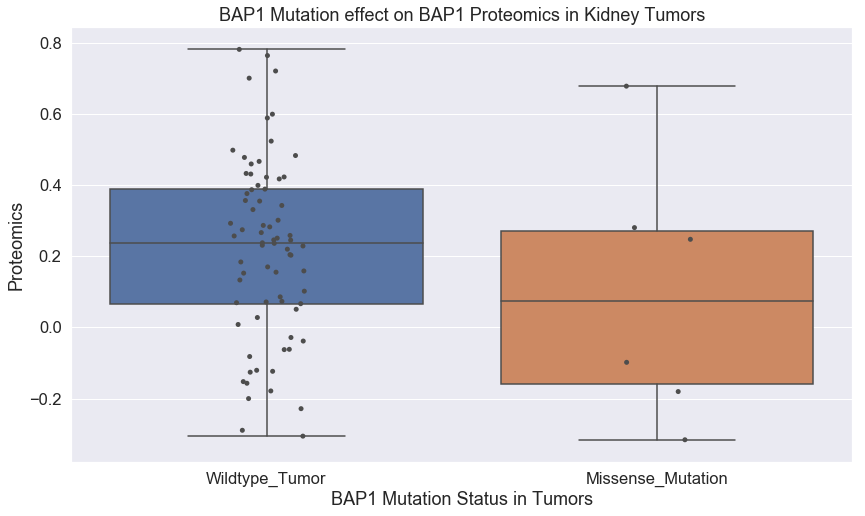

In [123]:
#take out if not sig --del later
rc_cis_boxplot = sns.boxplot(data = formatted_mut_miss,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Mutation effect on "+gene+" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= formatted_mut_miss, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

Frame shift deletion

In [116]:
# filter: keep only frame shift del and wiltype
binary_mut = mutation_prot.query('BAP1_Mutation == @common_mut_list[1] or BAP1_Mutation == "Wildtype_Tumor"')

#format
formatted_mut = binary_mut[[gene+'_proteomics', gene+'_Mutation']]
#formatted_mut['BAP1_Mutation'].value_counts()

# T-test
print("Doing t-test comparison for Frame_Shift_Del and Wildtype_Tumor\n")
significant_pval_results = al.wrap_ttest(formatted_mut, gene+'_Mutation', [gene+'_proteomics'])
print(significant_pval_results)

Doing t-test comparison for Frame_Shift_Del and Wildtype_Tumor

No significant comparisons.
None


Visualize all mutation types

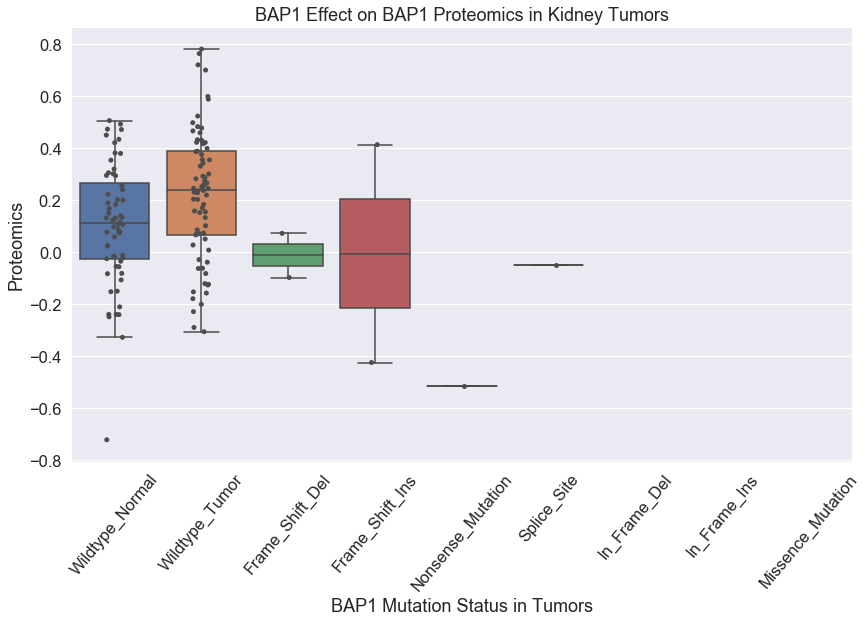

In [122]:
# todo- rotate x 
plt.rcParams['figure.figsize']=(14,8)
sns.set(font_scale = 1.5)
rc_cis_boxplot = sns.boxplot(data = mutation_prot,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missence_Mutation'],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on " + gene +" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= mutation_prot, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missence_Mutation'],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
rc_cis_boxplot.set_xticklabels(rc_cis_boxplot.get_xticklabels(),rotation = 50)
plt.show()
plt.clf()
plt.close()

SURPRISING  that the normal is lower than wildtype tumor

# Common mutation locations

In [21]:
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                        omics_genes=gene)
tumors = mutation_prot.loc[mutation_prot['Sample_Status'] == 'Tumor']
tumors['BAP1_Location'].value_counts()

[No_mutation]         93
[p.G185E]              1
[p.L183Sfs*10]         1
[p.X686_splice]        1
[p.W52G]               1
[p.F170L]              1
[p.T254Dfs*30]         1
[p.T93A]               1
[p.S473Wfs*95]         1
[p.Q436*]              1
[p.D73*]               1
[p.S113Tfs*70]         1
[p.P618Lfs*5]          1
[p.Q28_V29delinsL]     1
[p.F170C]              1
[p.N2I]                1
[p.S473Vfs*98]         1
[p.K337*]              1
Name: BAP1_Location, dtype: int64

In [14]:
gene_mutations['Location'].value_counts()
gene_mutations

,Sample_ID,Gene,Mutation,Location
0,S003,BAP1,Frame_Shift_Del,p.S473Wfs*95
1,S014,BAP1,Frame_Shift_Del,p.P618Lfs*5
2,S019,BAP1,Frame_Shift_Del,p.S473Vfs*98
3,S029,BAP1,Missense_Mutation,p.F170C
4,S030,BAP1,Missense_Mutation,p.F170L
5,S034,BAP1,Frame_Shift_Ins,p.D73*
6,S040,BAP1,Missense_Mutation,p.G185E
7,S051,BAP1,Missense_Mutation,p.T93A
8,S054,BAP1,Missense_Mutation,p.W52G
9,S085,BAP1,Splice_Site,p.X686_splice


# Analysis of Results

BAP1 proteomics decreased for the BAP1 mutated samples compared to the wildtype in the kidney dataset.
